# Classification
[![Run in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bobmh43/handson_ml/blob/master/notebooks/ch3_classification.ipynb)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn

An exercise in re-implementing Geron's code in chapter 3.

what we will do:

*  binary classifier: sgdclassifier,
* evaluate the classifier: confusion matrix, prec, recall; mpr curve, roc, auc,
* multiclass classifier: sgd (ova), ovo,
*evaluate multiclass: confusion matrix, scaled by class sizes
*use the idea of an multi output classifier to create a image bg remover



**Wrangling MNIST**: sorting it by label, and describing it:

data: (70000,784), target: (70000,)

In [ ]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

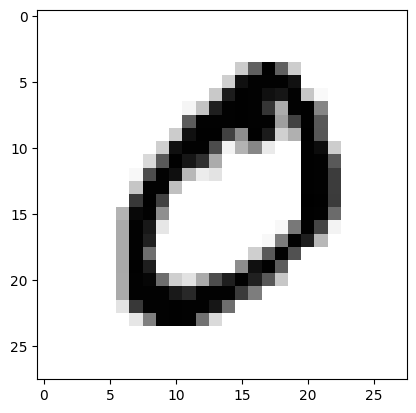

In [ ]:
#sample image
img1 = mnist.data[0].reshape((28,28))
plt.imshow(img1, cmap=mpl.cm.binary, interpolation="nearest")

In [ ]:
#train_test split
X_train = mnist.data[:60000]
y_train = mnist.target[:60000]
X_test = mnist.data[60000:]
y_test = mnist.target[60000:]

#**Binary Classifier**

training and evaluation

##*basic training and evaluation:*


* split into train and validation
* fit using X_train and y_train
* predict using X_test
* calculate a scoring metric using y_test, y_pred

In [ ]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

KeyboardInterrupt: 

In [ ]:
y_pred_5 = sgd_clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cm = confusion_matrix(y_test_5, y_pred_5, normalize="true")
plt.matshow(cm, cmap=mpl.cm.gray)
print(f"precision: {cm[1,1] / (cm[0,1] + cm[1,1])}") #could have called sklearn.metrics.precision_score()
print(f"recall: {cm[1,1] / (cm[1,0] + cm[1,1])}")
print(f"FPR: {cm[0,1] / (cm[0,0] + cm[0,1])}")
print(f"f1_score: {f1_score(y_test_5, y_pred_5)}")

##*cross validation training and evaluation*

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()

from sklearn.model_selection import cross_val_predict
y_confidence_score_5 = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")[:, 1]

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_confidence_score_5)
def plot_PR(precisions, recalls):
  plt.plot(recalls, precisions, linewidth=2)
  plt.axis([0, 1, 0, 1])
  plt.xlabel("Recall")
  plt.ylabel("Precision")
plot_PR(precisions, recalls)
plt.show()

In [ ]:
fpr, tpr, thresholdss = roc_curve(y_train_5, y_confidence_score_5)
def plot_ROC(tpr, fpr):
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0,1], [0,1], "k--")
  plt.axis([0, 1, 0, 1])
  plt.xlabel("FPR")
  plt.ylabel("TPR")
plot_ROC(tpr, fpr)
plt.show()

#**multiclass classification**

##*multiclass classifier basic fitting and scoring*

In [ ]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train) #automatically does OvA (10 binary classifiers)

SGDClassifier()

In [ ]:
y_pred = sgd_clf.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(f"confusion matrix: {cm}")

row_sum = cm.sum(axis=1)
norm_cm = cm / row_sum[:, np.newaxis]

confusion matrix: [[ 934    0    2    3    1    4   13    1   20    2]
 [   0 1100   10    5    0    1    5    1   12    1]
 [   3    3  941   15   10    3   14    4   37    2]
 [   4    0   43  875    1   21    6    6   48    6]
 [   0    1   15    3  908    0   12    2   29   12]
 [   8    2    9   60   16  644   46    2   95   10]
 [   6    3    9    0    4    7  923    0    6    0]
 [   0    5   58   14    9    2    2  881   22   35]
 [   3   10   17   10    7    9   27    2  884    5]
 [   3    5    8   15  107    7    0   14  129  721]]


In [ ]:
cm2 = confusion_matrix(y_test, y_pred, normalize="true")

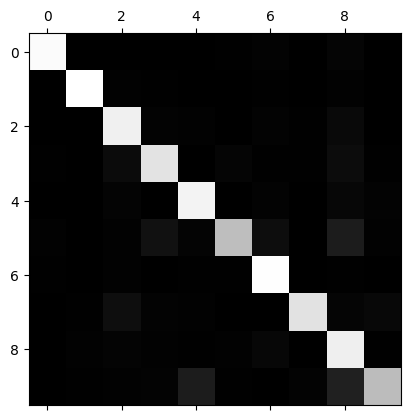

In [ ]:
plt.matshow(norm_cm, cmap=plt.cm.gray)

##*multiclass classifier cross validation*

In [ ]:
forest_clf2 = RandomForestClassifier()
y_train_pred = cross_val_predict(forest_clf2, X_train, y_train, cv=3, n_jobs=-1)
cm = confusion_matrix(y_train, y_train_pred, normalize="true")
np.fill_diagonal(cm, 0)
plt.matshow(cm, cmap=mpl.cm.gray)

#**multilabel binary classification**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

y_train_large = y_train >= 7
y_train_odd = y_train %2 == 1
y_train_multilabel = np.column_stack((y_train_large, y_train_odd)) #not vstack, not hstack, but column_stack
#y_multilabel = np.c_[y_train_large, y_train_odd] #alternatively

y_test_large = y_test >= 7
y_test_odd = y_test %2 == 1
y_test_multilabel = np.column_stack((y_test_large, y_test_odd))

In [ ]:
knn_clf.fit(X_train, y_train_multilabel)

KNeighborsClassifier()

In [ ]:
y_pred = knn_clf.predict(X_test)

In [ ]:
f1 = f1_score(y_test_multilabel, y_pred, average="macro")
f1

0.9778834608379015

#**multioutput (multilabel, multiclass) classification**

using this to remove backgrounds from images


In [ ]:
#creating the noisy images
noise = np.random.randint(0, 100, X_train.shape)
X_train_noisy = X_train + noise
noise = np.random.randint(0, 100, X_test.shape)
X_test_noisy = X_test + noise
y_train_no = X_train
y_test_no = X_test

In [ ]:
knn_clf.fit(X_train_noisy, y_train_no)

KNeighborsClassifier()

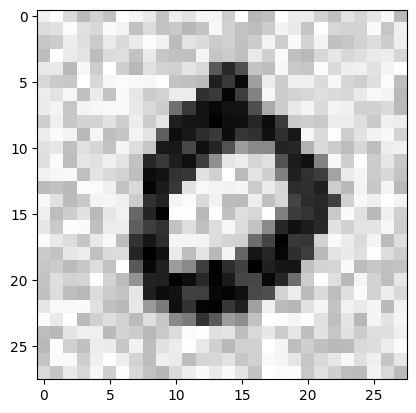

In [ ]:
plt.imshow(X_test_noisy[0].reshape((28,28)), cmap=mpl.cm.binary)

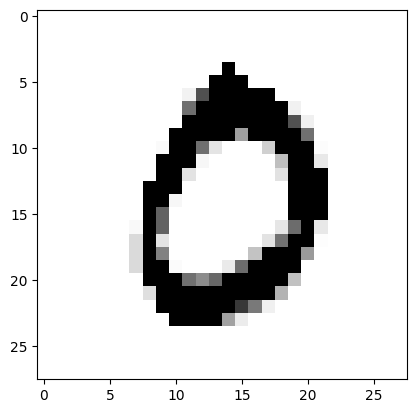

In [ ]:
plt.imshow(knn_clf.predict([X_test_noisy[0]]).reshape((28,28)), cmap=mpl.cm.binary)

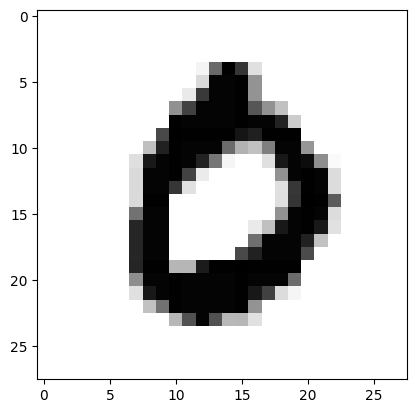

In [ ]:
plt.imshow(y_test_no[0].reshape((28,28)), cmap=mpl.cm.binary)